# Logistic regression and clustering

For this homework you are going to create a data pipeline for multiclass logistic regression. 

In this homework you will perform the steps required for data exploration and for the last question you will create a data pipeline that will perform all of the these steps. You will be using a cardiotocography data set available on the UC Irvine repository [here](http://archive.ics.uci.edu/ml//datasets/Cardiotocography).

# Multiclass Logistic Regression

## 1) Import the required packages and get the data into a usable format, i.e. get the proper columns, check data types and drop NaN values.

Below is a list of the data that is in the file. Use that information to extract the useful part of the data in the file. Our dependent variable is NSP which has 3 classes : 1=normal; 2=suspect; 3=pathologic

In [292]:
# Stacking the imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from math import sqrt


from IPython.display import display, HTML
pd.get_option("display.max_columns")

20

In [293]:
# df = pd.read_excel(r'CTG.xls')
xl = pd.ExcelFile("CTG.xls")

# Parsing through the sheets in the xcel file
xl_sheets = [xl.parse(sheet) for sheet in xl.sheet_names]

# diplaying length of sheet
display(len(xl_sheets))

# displaying sheet names
display(xl.sheet_names)

# placing data files into pandas
df = xl_sheets[1].copy()
df_raw = xl_sheets[2].copy()


# Adjustint the column names for df
display(df.head())
df.rename(columns=df.iloc[0], inplace=True)
df = df.iloc[1: , :]
display(df.head())

3

['Description', 'Data', 'Raw Data']

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,22,Unnamed: 44,23
0,b,e,AC,FM,UC,DL,DS,DP,DR,NaN,...,E,AD,DE,LD,FS,SUSP,NaN,CLASS,NaN,NSP
1,240,357,0,0,0,0,0,0,0,NaN,...,-1,-1,-1,-1,1,-1,NaN,9,NaN,2
2,5,632,4,0,4,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1
3,177,779,2,0,5,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1
4,411,1192,2,0,6,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1


,b,e,AC,FM,UC,DL,DS,DP,DR,NaN,...,E,AD,DE,LD,FS,SUSP,NaN,CLASS,NaN,NSP
1,240,357,0,0,0,0,0,0,0,NaN,...,-1,-1,-1,-1,1,-1,NaN,9,NaN,2
2,5,632,4,0,4,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1
3,177,779,2,0,5,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1
4,411,1192,2,0,6,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1
5,533,1147,4,0,5,0,0,0,0,NaN,...,-1,-1,-1,-1,-1,-1,NaN,2,NaN,1


In [294]:
def display_and_drop(df):
    """This Function displays the original Dataframe and drops it"""
    # Display original shape
    display("Original Shape", df.shape)

    # Displaying a heat map of the head 100
    plt.figure(figsize=(10,10))
    sns.heatmap(df.head(100).isna().transpose(),cbar_kws={'label': 'MaNs'})
    plt.show()

    # Dropping the rows that have all NaNs. First row appears to be that way
    # Dropping Rows that consist of all NA's
    df.dropna(axis=0, how='all', inplace=True)

    # Dropping Columns that consist of all NA's
    df.dropna(axis=1, how='all', inplace=True)

    # Displaying shape to show change
    display(df.shape)

    # Displaying a cleanded heat map of the head 100
    plt.figure(figsize=(10,10))
    sns.heatmap(df.head(130).isna().transpose(),cbar_kws={'label': 'MaNs'})
    plt.show()

    # Displaying the new Head
    display(df.head())

    # Displaying tail
    display(df.tail())
    
    # Clipping the last two fields
    df = df.iloc[:-2]
    display(df.tail())

    # Collecting the features that are required
    fields_to_keep = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width',
                 'Min', 'Max', 'Nmax', 'Mode' , 'Mean','Median','Variance', 'Tendency', 'CLASS', 'NSP' ,'Nzeros']
    df = df[fields_to_keep].copy()


    return df


'Original Shape'

(2130, 40)

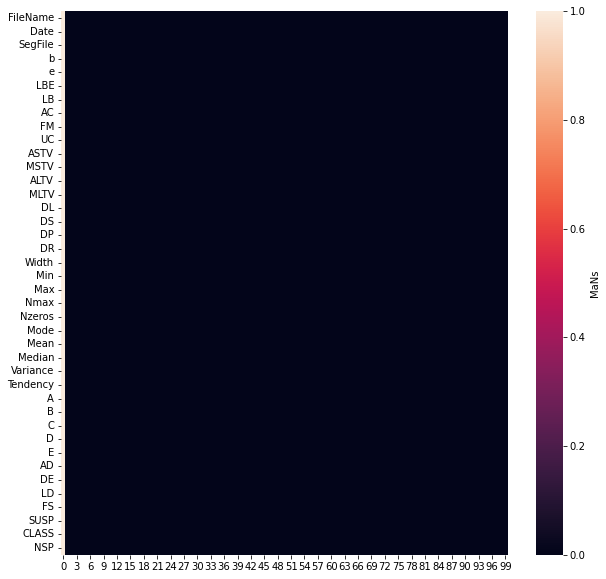

(2128, 40)

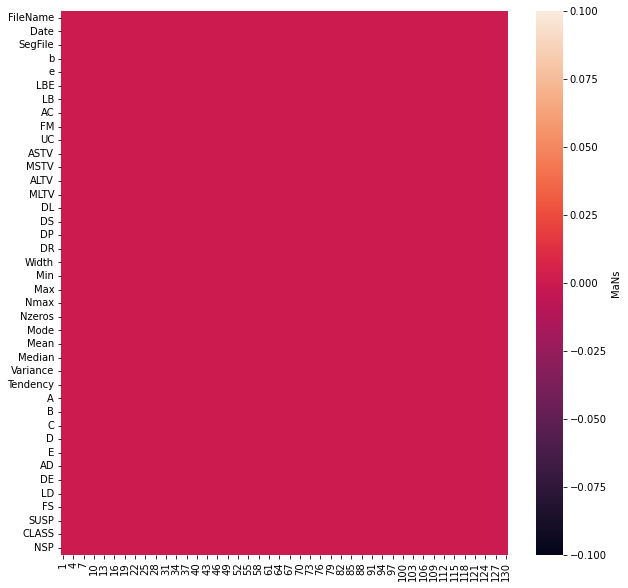

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
1,Variab10.txt,1996-12-01,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
2,Fmcs_1.txt,1996-05-03,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,1996-05-03,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,1996-05-03,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
5,Fmcs_1.txt,1996-05-03,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
2124,S8001045.dsp,1998-06-06,CTG2126.txt,1576.0,2596.0,140.0,140.0,1.0,0.0,7.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2125,S8001045.dsp,1998-06-06,CTG2127.txt,1576.0,3049.0,140.0,140.0,1.0,0.0,9.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2126,S8001045.dsp,1998-06-06,CTG2128.txt,2796.0,3415.0,142.0,142.0,1.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2128,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2129,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,564.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
2122,S8001045.dsp,1998-06-06,CTG2124.txt,2059.0,2867.0,140.0,140.0,0.0,0.0,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2123,S8001045.dsp,1998-06-06,CTG2125.txt,1576.0,2867.0,140.0,140.0,1.0,0.0,9.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2124,S8001045.dsp,1998-06-06,CTG2126.txt,1576.0,2596.0,140.0,140.0,1.0,0.0,7.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2125,S8001045.dsp,1998-06-06,CTG2127.txt,1576.0,3049.0,140.0,140.0,1.0,0.0,9.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2126,S8001045.dsp,1998-06-06,CTG2128.txt,2796.0,3415.0,142.0,142.0,1.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


'Original Shape'

(2129, 46)

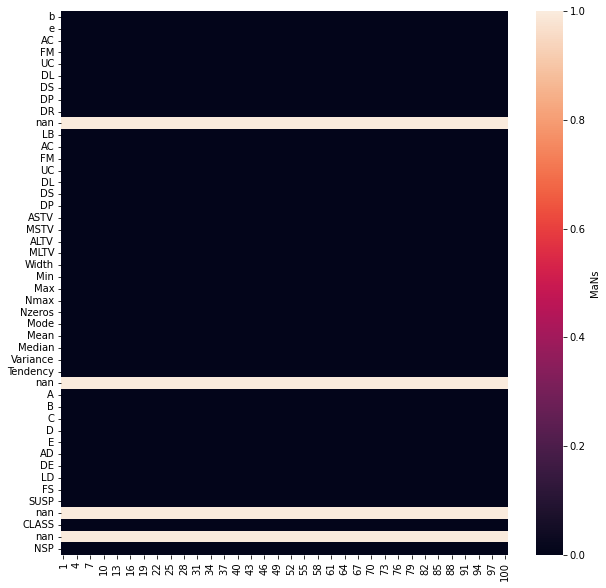

(2128, 42)

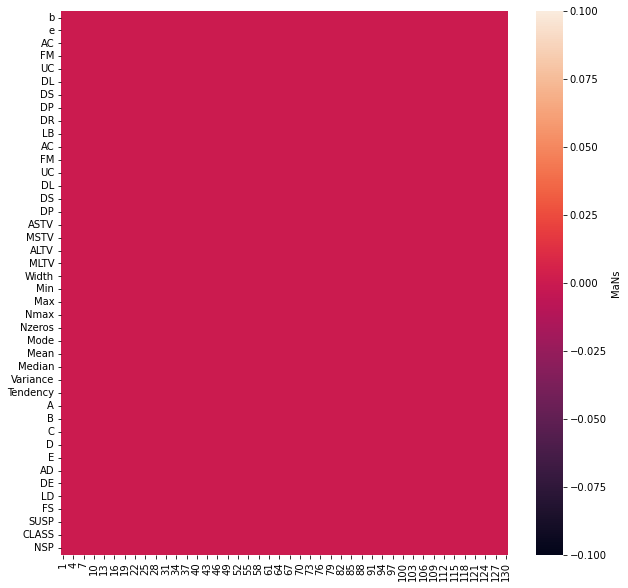

,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
1,240,357,0,0,0,0,0,0,0,120,...,-1,-1,-1,-1,-1,-1,1,-1,9,2
2,5,632,4,0,4,2,0,0,0,132,...,-1,-1,-1,1,-1,-1,-1,-1,6,1
3,177,779,2,0,5,2,0,0,0,133,...,-1,-1,-1,1,-1,-1,-1,-1,6,1
4,411,1192,2,0,6,2,0,0,0,134,...,-1,-1,-1,1,-1,-1,-1,-1,6,1
5,533,1147,4,0,5,0,0,0,0,132,...,-1,-1,-1,-1,-1,-1,-1,-1,2,1


,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
2124,1576,2596,1,0,7,0,0,0,0,140,...,-1,-1,1,-1,-1,-1,-1,-1,5,2
2125,1576,3049,1,0,9,0,0,0,0,140,...,-1,-1,1,-1,-1,-1,-1,-1,5,2
2126,2796,3415,1,1,5,0,0,0,0,142,...,-1,-1,-1,-1,-1,-1,-1,-1,1,1
2128,NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN,...,53,81,72,332,252,107,69,197,NaN,NaN
2129,NaN,NaN,NaN,564,23,16,1,4,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
2122,2059,2867,0,0,6,0,0,0,0,140,...,-1,-1,1,-1,-1,-1,-1,-1,5,2
2123,1576,2867,1,0,9,0,0,0,0,140,...,-1,-1,1,-1,-1,-1,-1,-1,5,2
2124,1576,2596,1,0,7,0,0,0,0,140,...,-1,-1,1,-1,-1,-1,-1,-1,5,2
2125,1576,3049,1,0,9,0,0,0,0,140,...,-1,-1,1,-1,-1,-1,-1,-1,5,2
2126,2796,3415,1,1,5,0,0,0,0,142,...,-1,-1,-1,-1,-1,-1,-1,-1,1,1


In [295]:
df_raw = display_and_drop(df_raw).copy()
df = df = display_and_drop(df).copy()

These are the fields that we need to keep from our file :

LB - FHR baseline (beats per minute) 

AC - # of accelerations per second 

FM - # of fetal movements per second 

UC - # of uterine contractions per second 

DL - # of light decelerations per second 

DS - # of severe decelerations per second 

DP - # of prolongued decelerations per second 

ASTV - percentage of time with abnormal short term variability 

MSTV - mean value of short term variability 

ALTV - percentage of time with abnormal long term variability 

MLTV - mean value of long term variability 

Width - width of FHR histogram 

Min - minimum of FHR histogram 

Max - Maximum of FHR histogram 

Nmax - # of histogram peaks 

Nzeros - # of histogram zeros 

Mode - histogram mode 

Mean - histogram mean 

Median - histogram median 

Variance - histogram variance 

Tendency - histogram tendency 

CLASS - FHR pattern class code (1 to 10) 

NSP - fetal state class code (N=normal; S=suspect; P=pathologic)

In [296]:
# fields_to_keep = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width',
#                  'Min', 'Max', 'Nmax', 'Mode' , 'Mean','Median','Variance', 'Tendency', 'CLASS', 'NSP' ,'Nzeros']
df.head()


,LB,AC,AC,FM,FM,UC,UC,DL,DL,DS,...,Max,Nmax,Mode,Mean,Median,Variance,Tendency,CLASS,NSP,Nzeros
1,120,0,0,0,0,0,0,0,0,0,...,126,2,120,137,121,73,1,9,2,0
2,132,4,0.00638,0,0,4,0.00638,2,0.00319,0,...,198,6,141,136,140,12,0,6,1,1
3,133,2,0.003322,0,0,5,0.008306,2,0.003322,0,...,198,5,141,135,138,13,0,6,1,1
4,134,2,0.002561,0,0,6,0.007682,2,0.002561,0,...,170,11,137,134,137,13,1,6,1,0
5,132,4,0.006515,0,0,5,0.008143,0,0,0,...,170,9,137,136,138,11,1,2,1,0


## 2) Perform feature selection and remove features that exhibit strong colinearity (>|0.8|) and remove those which do not have strong correlation with the outcome variable (< |0.1|)

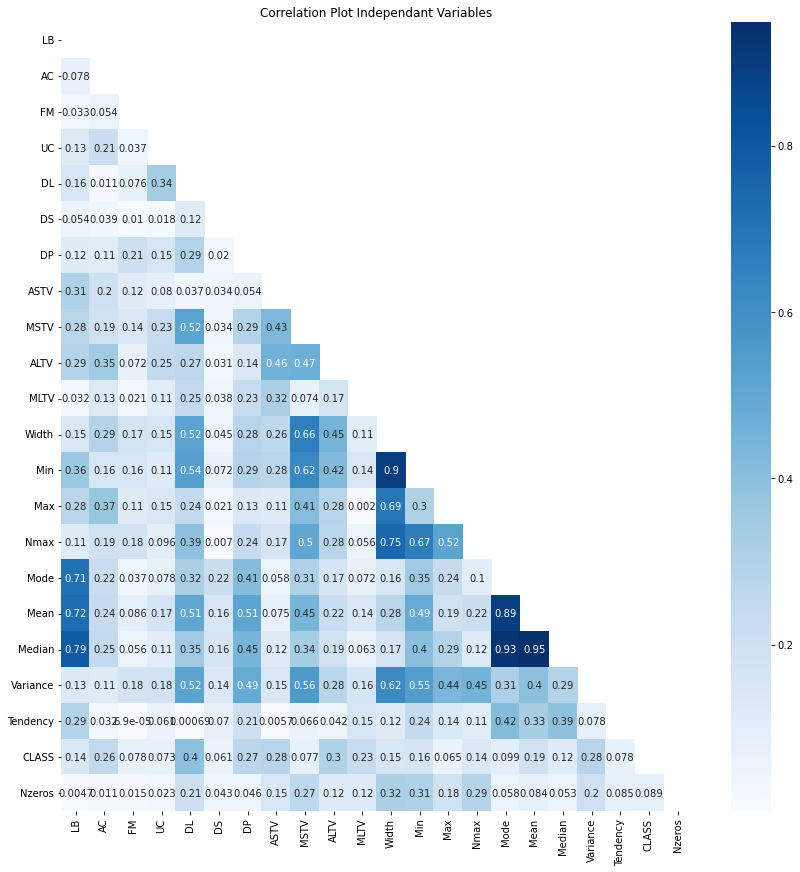

In [297]:

# Displaying first round of colinearity of above 0.8
X_all = df_raw.loc[:, df_raw.columns != 'NSP'].copy()
Y_all = df_raw.loc[:, df_raw.columns == 'NSP'].copy()

plt.figure(figsize=(12,12))
sns.heatmap(X_all.corr().abs(), annot=True, mask=np.triu(X_all.corr()), cmap="Blues")
plt.tight_layout()
plt.title('Correlation Plot Independant Variables')
plt.show()

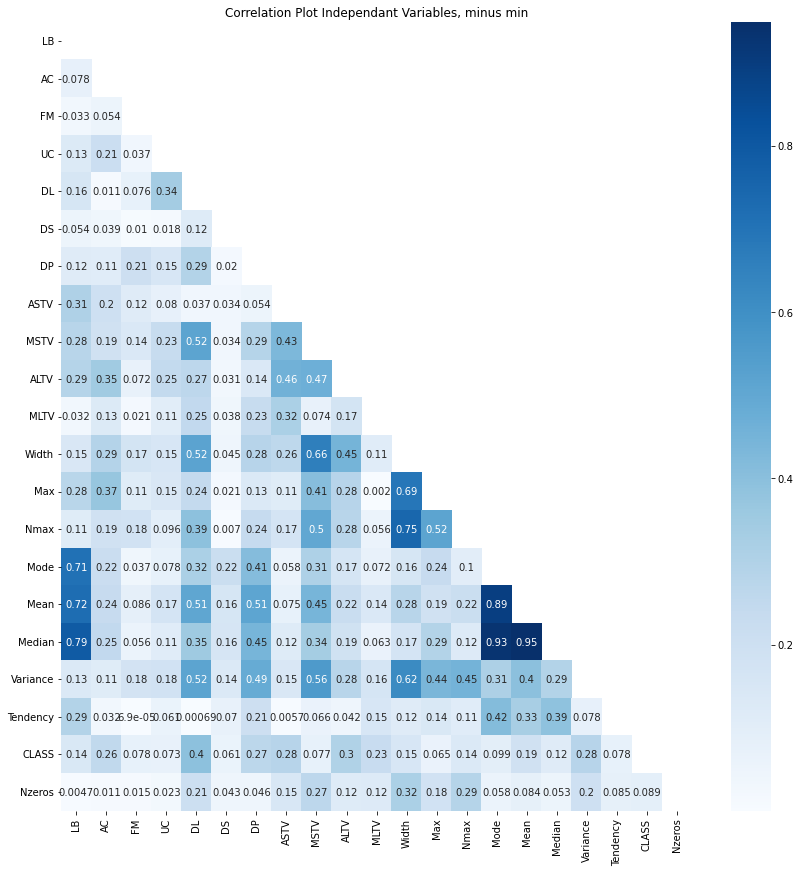

In [298]:
# Removing Min
drop_list = ['Min']
X_all.drop(columns=drop_list, inplace=True)

plt.figure(figsize=(12,12))
sns.heatmap(X_all.corr().abs(), annot=True, mask=np.triu(X_all.corr()), cmap="Blues")
plt.tight_layout()
plt.title('Correlation Plot Independant Variables, minus min')
plt.show()


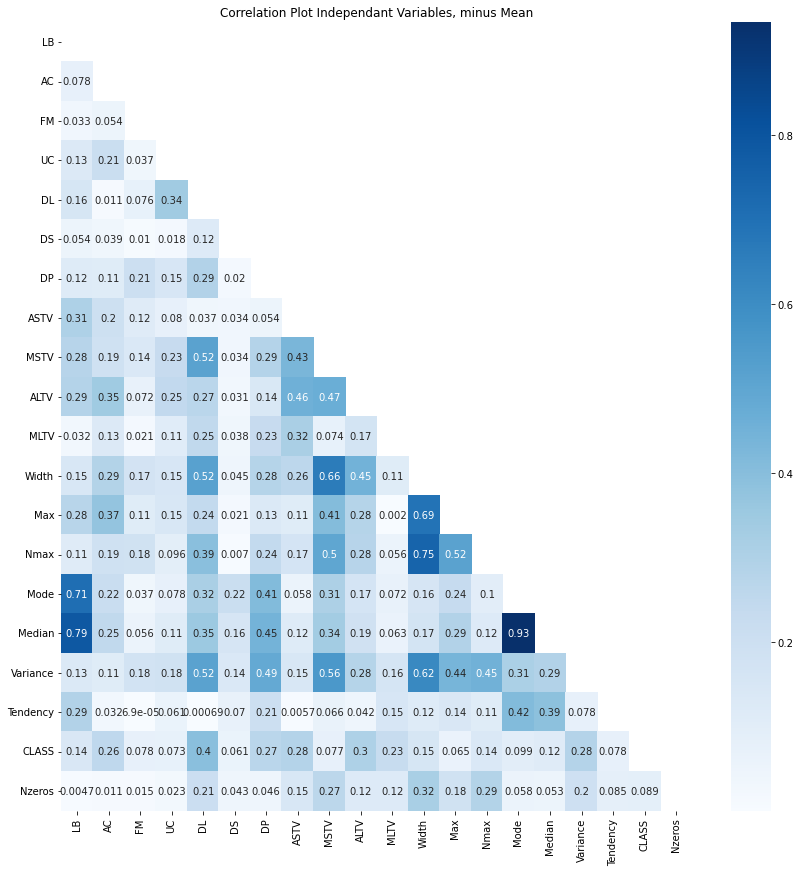

In [299]:
# Removing Mean
drop_list = ['Mean']
X_all.drop(columns=drop_list, inplace=True)

plt.figure(figsize=(12,12))
sns.heatmap(X_all.corr().abs(), annot=True, mask=np.triu(X_all.corr()), cmap="Blues")
plt.tight_layout()
plt.title('Correlation Plot Independant Variables, minus Mean')
plt.show()

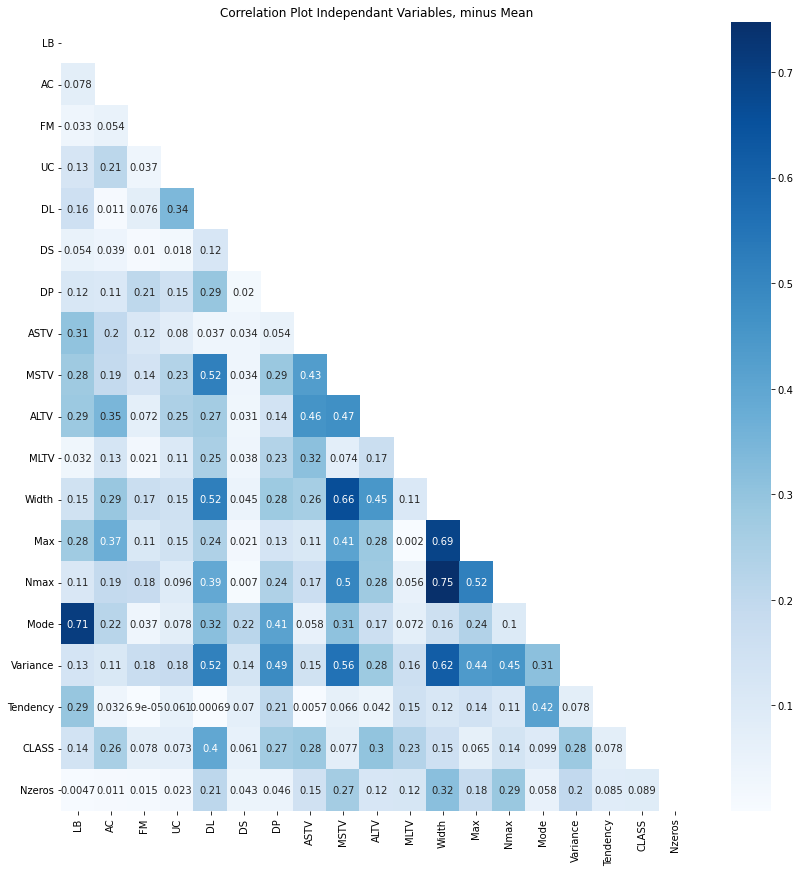

In [301]:
# Removing  Median
drop_list = ['Median']
X_all.drop(columns=drop_list, inplace=True)

plt.figure(figsize=(12,12))
sns.heatmap(X_all.corr().abs(), annot=True, mask=np.triu(X_all.corr()), cmap="Blues")
plt.tight_layout()
plt.title('Correlation Plot Independant Variables, minus Mean')
plt.show()

In [302]:
# Officially Dropping all the correlation values above 0.8
df.drop(columns=['Min', 'Median', 'Mean'], inplace=True)

In [ ]:
# Looking at the correlations with NSP


## 3) Split the data into train/test split (70/30). Check for class imbalance and deal with it if needed. Check that your classes are balanced.

## 4) Construct the logistic regression model using sklearn on the the cleaned data set with the selected features and on the full data set (the data you had at the beginning of question 2).

## Check both model's performance using a confusion matrix. Which shows better results ? Which model is better and why ?

Building the model on the reduced data set :

Building the model on the full data set :

## 5) Create a pipeline that will perform all of the previous steps.

# Clustering

For this section of the homework you will be using data where 12 users were asked to reproduce a certain number of hand gestures. Using clustering you will find the number of hand gestures made by the users. The dataset is available [here](http://archive.ics.uci.edu/ml//datasets/MoCap+Hand+Postures).

## 1) Import the data and necessary packages. Check data types, remove columns that contain fewer than 60k valid inputs.

In [ ]:
df_c = pd.read_csv('allUsers.lcl.csv')
df_c.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,?,?,?,?,?,?,?,?,?,?
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,?,?,?,?,?,?,?,?,?,?
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,?,?,?,?,?,?,?,?,?,?
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,?,?,?,?,?,?,?,?,?,?


## 2) Check how many invalid inputs there are for each column and then drop any rows that contain invalid input

## 3) Scale the data with the MinMaxScaler. 

## Using the silhouette score method check what the optimal number of clusters there is for the data, i.e. how many hand gestures were participants asked to perform ? 

## How confident can you be about the number of clusters ? What do the Silhouette scores tell you about the clusters ?

The silhouette score is a floating point value that is defined in the range $[-1, 1]$. The closer the value is to 1 the better the clustering model performs. It gives a perspective into the density and separation of the formed clusters. sklearn has an implementation for the silhouette score and has great documentation for it.

Keep in mind that the data set you're working with has several tens of thousands of observations so checking for the number of clusters will take ~10 min depending on your machine.

## 4) Implement a data pipeline that will perform all of the previous steps.